In [11]:
### Note for the homework: You can add further images or comments in the submitted PDF file if you don't want to do it here.

from google.colab import drive
drive.mount('/content/drive')

# path to store the data
%cd /content/drive/My Drive/dl4nlp_2023/

Mounted at /content/drive
/content/drive/My Drive/dl4nlp_2023


In [85]:
# Run this cell to intall/import all denpendicies needed for this homework; you can also add arbitrary libararies.

!pip install datasets
from datasets import load_dataset
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
from nltk import word_tokenize
import nltk
nltk.download('punkt')
from scipy.stats import pearsonr, kendalltau
from pprint import pprint 
import matplotlib.pyplot as plt
import gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [86]:
# This function is used to specify the random seeds that could impact pytorch.

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.set_default_tensor_type(torch.DoubleTensor) #added to avoid datatype problems

# **Task 1: Getting to Know Pytorch: Semantic Textual Similarity**

In this task, we define semantic textual similarity (STS) as a **supervised** regression task in which the semantic similarity of two pieces of text (typically sentences) should be determined. 

### **Task 1.1: Data Preparation**

**Run the following cell to load the dataset for this task first**. Each entry of this dataset contains one English sentence pair and their similarity score. 

To get familiar with the data format, please **print** the first entry of `train_set`, the size of `dev_set`, and the first 3 `sentence1` in `train_set`.

**Hint**: the data is structured like both Python dictionary and Pandas DataFrame.



In [87]:
train_set = load_dataset("stsb_multi_mt", "en", split='train')
dev_set = load_dataset("stsb_multi_mt", "en", split='dev')

dev_set

Dataset({
    features: ['sentence1', 'sentence2', 'similarity_score'],
    num_rows: 1500
})

Useful documentation of the dataset

https://huggingface.co/datasets/stsb_multi_mt

In [88]:
# TODO: YOUR CODE HERE
print(f"First Entry:  {train_set[0]}")
print(f"Size of dev set: {len(dev_set)}")
print('First 3 sentence1 in train_set:', train_set["sentence1"][:3])

First Entry:  {'sentence1': 'A plane is taking off.', 'sentence2': 'An air plane is taking off.', 'similarity_score': 5.0}
Size of dev set: 1500
First 3 sentence1 in train_set: ['A plane is taking off.', 'A man is playing a large flute.', 'A man is spreading shreded cheese on a pizza.']


## **Task 1.1.1: Embed the sentences**
We will use the averages of the words' [FastText embeddings](https://fasttext.cc/docs/en/english-vectors.html) to embed both sentences. 

**Run the following cell to download the embeddings.**

In [89]:
# download word emebddings to your drive and unzip the file (run this cell only when you haven't downloaded the emb file yet.)
"""!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip"""

'!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip\n!unzip wiki-news-300d-1M.vec.zip'

### a) 
Implement a funtion to read the word embeddings into a Python dictionary that maps every token to the corresponding vector. Represent the vectors as Numpy arrays. Only load the embeddings of the first 40,000 tokens in the file. 

**Print** the size of the dictionary and the first 20 dimensions of the embedding for word "homework".

In [90]:
import numpy as np
import gensim
from gensim.models import KeyedVectors

def load_embeddings(file="wiki-news-300d-1M.vec", limit=40000):
  # TODO: YOUR CODE HERE
  embeddings = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/dl4nlp_2023/wiki-news-300d-1M.vec", binary=False, limit=limit)

  out = {}
  all_words = embeddings.index_to_key
  for w in all_words:
    out[w] = embeddings[w]

  return out

word_embedding_dict = load_embeddings() 


In [91]:
print("First 20 dimensions of homework: \n", word_embedding_dict["homework"][:20])
print("\n")
print("Size of dictionary: ", len(word_embedding_dict))

First 20 dimensions of homework: 
 [-0.1756  0.0695  0.0847  0.0988 -0.1196 -0.1389 -0.0379  0.0543  0.1022
 -0.0082 -0.0488 -0.1748 -0.0181 -0.131  -0.1794  0.2143 -0.1612 -0.113
  0.0213 -0.0763]


Size of dictionary:  40000


In [92]:
SHAPE_EMBEDDING = word_embedding_dict["homework"].shape
ss = word_embedding_dict["homework"].shape
len(np.zeros(ss))

300

### b)
Implement a function that tokenizes a sentence using [nltk.word_tokenize](https://www.nltk.org/book/ch03.html#accessing-text-from-the-web-and-from-disk) and returns a list of tokens for given sentence.

**Print** the tokenized sentence1 and sentence2 of the first entry in the training set. 

In [93]:
def tokenize(sentence):
  # TODO: YOUR CODE HERE
  return nltk.word_tokenize(sentence)

s1 = train_set[0]["sentence1"]
s2 = train_set[0]["sentence2"]

s1_tokenized = tokenize(s1)
s2_tokenized = tokenize(s2)

print(f"sentence1 : {s1_tokenized}")
print(f"sentence2 : {s2_tokenized}")

sentence1 : ['A', 'plane', 'is', 'taking', 'off', '.']
sentence2 : ['An', 'air', 'plane', 'is', 'taking', 'off', '.']


### c)
Implement a function that maps a sentence to its embedding. The sentence-level embedding should be the average of the embeddings of its tokens. If a token does not exist in the vocabulary of FastText, embed this token as a 0-vector with the same dimensions as the FastText embeddings.

**Print** the shape and the first 20 dimensions of sentence1's embedding of the first entry in the training set.


In [94]:
def embed_sentence(sentence, word2emb):
  # TODO: YOUR CODE HERE
  sum_embeddings = np.zeros(SHAPE_EMBEDDING)
  tokenized_sentence = tokenize(sentence)
  nb_word_in_sentence = len(tokenized_sentence) 
  all_words_dict = word2emb.keys() #get all words in the dict
  for word in tokenized_sentence:
    #check whether the word has an embedding
    if word in all_words_dict:
      emb = np.array(word2emb[word])
      sum_embeddings += emb
    #else block unecessary since adding zero numpy array does not change the outcome
  # average the embeddings
  return sum_embeddings / nb_word_in_sentence

In [95]:
sent1_emb = embed_sentence(train_set[0]["sentence1"], word_embedding_dict) #get the embedding of the first sentence of the training set
print(f"Shape : {sent1_emb.shape}\n")
print(f"First 20 dimensions : \n{sent1_emb[:20]}")

Shape : (300,)

First 20 dimensions : 
[ 0.01895     0.01555    -0.03663333  0.04301667 -0.05261667 -0.043
 -0.05235    -0.02503333 -0.01348333 -0.02275     0.023      -0.00196667
  0.01398333 -0.01931667  0.04275     0.02686667 -0.00416667  0.05871667
 -0.06091667  0.0174    ]


## **Task 1.1.2: Build Custom Dataset**


### a)
Implement a custom dataset class inheriting [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#data-loading-order-and-sampler) and override the following methods:
- `__len__`: which returns the size of the dataset.
- `__getitem__`: to support the indexing such that dataset[i] can be used to get `ith` sample. 

The `ith` sample should be a Python dict with two entries: 
- `encoding` the encoding of one sentence pair, which is the concatenation of the embeddings of the two sentences of a pair. E.g., sent1 = [1,2], sent2 = [3,4], the encoding for sent1 and sent2 should be [1,2,3,4].
- `score` the similarity score between the two sentences.

**Hint**: examples can be found here: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [96]:
class MLPDataset(Dataset):
  def __init__(self, sents_1, sents_2, scores):
    """
    Arguments:
      sents_1 (List[string]): the list of the first sentences.
      sents_2 (List[string]): the list of the second sentences.
      scores (List[float]): the list of the similarity scores.
    """
    # TODO: YOUR CODE HERE
    #initialize params
    self.sents_1 = sents_1
    self.sents_2 = sents_2
    self.scores = scores
    self.word_embedding_dict = word_embedding_dict
  
  def __getitem__(self, idx):
    # TODO: YOUR CODE HERE
    #get the embeddings of the sentences as a normal list
    s1_embedding = embed_sentence(self.sents_1[idx], self.word_embedding_dict).tolist()
    s2_embedding = embed_sentence(self.sents_2[idx], self.word_embedding_dict).tolist()

    encoding = np.array(s1_embedding + s2_embedding)

    return {
        "encoding": encoding,
        "score": self.scores[idx]
    }

  def __len__(self):
    # TODO: YOUR CODE HERE
    return len(self.sents_1)

### b)
Instantiate the above class for our `train_set` and `dev_set`.

**Print** the size of `dev_dataset` and the shape of the encoding of the first example.

In [97]:
# TODO: YOUR CODE HERE
train_dataset = MLPDataset(train_set["sentence1"], train_set["sentence2"], train_set["similarity_score"])
dev_dataset = MLPDataset(dev_set["sentence1"], dev_set["sentence2"], dev_set["similarity_score"])

In [98]:
len(train_dataset.__getitem__(2)["encoding"])

600

In [99]:
print(f"size of dev_dataset == {dev_dataset.__len__()}")
print("shape of encoding of the first example == ", dev_dataset.__getitem__(0)["encoding"].shape)

size of dev_dataset == 1500
shape of encoding of the first example ==  (600,)


## **Task 1.2: Scoring the Similarity**
We will train a simple multi-layer perceptron (MLP) to score the similarity of the two sentences. 

### **Task 1.2.1: Build MLP using Pytorch**

We will use [`pytorch.nn`](https://pytorch.org/docs/stable/nn.html) to build our MLP. 

Implement a class inheriting [`pytorch.nn.Module`]() for our MLP, which has the following components:
- A [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) with 1,200 dimensions and [relu activation](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) , which takes the encoding of one sentence pair as the input.
- A [dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout) with probability 0.1.
- A linear layer with 600 dimensions and relu activation.
- A dropout layer with probability 0.1.
- A linear layer with 300 dimensions and relu activation.
- A dropout layer with probability 0.1.
- A linear layer with 1 dimension (output layer). 

**Hint**: 
- You need to override the method `forward` in this class
- Use `nn.Sequential` to sequentialize the layers.
- You may want to see a quick example: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html?highlight=sequential


In [100]:
class MLP(nn.Module):
  def __init__(self):
    super(MLP, self).__init__()
    # TODO: YOUR CODE HERE
    self.sequential_layers = nn.Sequential(
            nn.Linear(600, 1200),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(1200, 600),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(600, 300),
            nn.ReLU(),
            nn.Dropout(p=0.1),
            nn.Linear(300, 1)
        )
  def forward(self, x):
    # TODO: YOUR CODE HERE
    return self.sequential_layers(x)

model = MLP()
print(model)

MLP(
  (sequential_layers): Sequential(
    (0): Linear(in_features=600, out_features=1200, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1200, out_features=600, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=600, out_features=300, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=300, out_features=1, bias=True)
  )
)


### **Task 1.2.2: Train MLP with Pytorch**
Train the MLP with the following setups/hyperparameters:
- [AdmW](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html#torch.optim.AdamW) with a learning rate of 2e-3 as the  optimizer
- [Mean Square Error](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) as the loss function
- batch size: 128
- number of training epochs: 17


### a)
The method for training is provided below, which returns the list of the train loss at all epochs and the trained model. Please define the corresponding parameters to call this method and **plot** the training loss using `matplotlib.pyplot.plot`; with GPU the training takes about 1.5 mins for 17 epochs. 

**Hint**: create the dataloader for the custom datasets (`train_dataset` and `dev_dataset`) using [`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader); reshuffle the training data at every epoch (don't forget to define the batch size for the dataloader!).



In [101]:
def train(model, train_dataloader, eval_dataloader, optimizer, loss_fn, num_epochs, device='cuda'):
  
  train_losses = []

  for epoch in range(num_epochs):

    if epoch == 0:
      model.eval()
      loss_per_epoch = 0
      for batch_data in train_dataloader:
        with torch.no_grad():
          predictions = model(batch_data['encoding'].to(device))
          targets = batch_data['score'].to(device) # only if device='cuda'
          train_loss = loss_func(predictions.squeeze(), targets)
          loss_per_epoch += train_loss.item()
      loss_per_epoch = loss_per_epoch/len(train_dataloader)
      train_losses.append(loss_per_epoch)
      print(f'\ninital train loss: {loss_per_epoch}')

    model.train()
    loss_per_epoch = 0
    for batch_data in train_dataloader:
      predictions = model(batch_data['encoding'].to(device))
      targets = batch_data['score'].to(device) # only if device='cuda'
      train_loss = loss_func(predictions.squeeze(), targets) 
      loss_per_epoch += train_loss.item()

      optimizer.zero_grad()
      train_loss.backward()
      optimizer.step()   

    loss_per_epoch = loss_per_epoch/len(train_dataloader)
    train_losses.append(loss_per_epoch)
    print(f'\n Epoch {epoch+1} train loss: {loss_per_epoch}')
    #evaluate(model, eval_dataloader, loss_func)
  
  return train_losses, model



In [102]:
# Set random seeds; do not change this!
seed_everything(seed=999)

# TODO: YOUR CODE HERE
# ==============================================

# Define the training hyperparameters
num_epochs = 17
batch_size = 128
learning_rate = 2e-3

# Create dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, batch_size=batch_size)

# Initialize the model
device = 'cuda' # "gpu"
model = MLP()
model.to(device)

# Define Optimizer and Loss Function
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
loss_func = nn.MSELoss()

train_losses, model = train(model, train_dataloader, dev_dataloader, optimizer, loss_func, num_epochs, 'cuda')

# YOUR CODE FOR PLOTTING HERE

# ==============================================


inital train loss: 9.514770823865772

 Epoch 1 train loss: 2.904914813172703

 Epoch 2 train loss: 2.1431487369775124

 Epoch 3 train loss: 2.072098582707661

 Epoch 4 train loss: 2.131613265854313

 Epoch 5 train loss: 1.998916331229936

 Epoch 6 train loss: 1.8769423414890987

 Epoch 7 train loss: 1.8302743190834552

 Epoch 8 train loss: 1.7623476238473068

 Epoch 9 train loss: 1.6421896324308383

 Epoch 10 train loss: 1.563925786286195

 Epoch 11 train loss: 1.4352797875875705

 Epoch 12 train loss: 1.314662154960458

 Epoch 13 train loss: 1.2712593050209375

 Epoch 14 train loss: 1.276536739402047

 Epoch 15 train loss: 1.5156666619219699

 Epoch 16 train loss: 1.3541686304839575

 Epoch 17 train loss: 1.1989442933208914


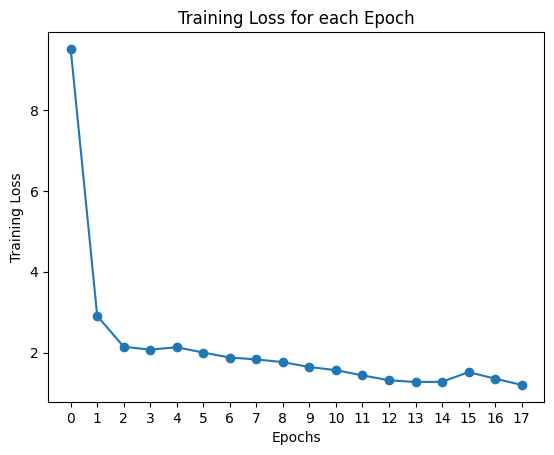

In [103]:
# YOUR CODE FOR PLOTTING HERE
def plot_epochs_loss(lst_epochs, lst_train_loss):
  plt.plot(lst_epochs, lst_train_loss, marker="o")
  plt.xticks(lst_epochs)
  plt.xlabel("Epochs")
  plt.ylabel("Training Loss")
  plt.title("Training Loss for each Epoch")
  plt.show()

epochs = list(range(0, 18))

plot_epochs_loss(epochs, train_losses)

### b)
Implement a method to evaluate a model which calculates the Pearson correlation between the predictions of the model and the similarity scores from the dataset.

**Print** the evaluation results  of your trained model on the dev set.

In [105]:
from scipy.stats import pearsonr
def evaluate(model, eval_dataloader):
  # TODO: YOUR CODE HERE:
  model.eval() # this is used to set the model in evlauation mode; details see https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval
  
  with torch.no_grad(): # this is used to disable gradient calculation; details see https://pytorch.org/docs/stable/generated/torch.no_grad.html 
    for batch_data in eval_dataloader:
      predictions = model(batch_data['encoding'].to(device))
      targets = batch_data['score'].to(device)
    # transform preds and targets to numpy in CPU to then use pearsonr
    preds_numpy = p.view(-1).cpu().numpy() #reshape and put on cpu
    targets_numpy = targets.cpu().numpy() #put on cpu
    
  return preds_numpy, targets_numpy, pearsonr(preds_numpy, targets_numpy)[0]

preds, targets, pearson_value = evaluate(model, dev_dataloader)
print(f"Pearson Correlation value == {pearson_value:.6f}")

Pearson Correlation value == 0.582735
